<a href="https://colab.research.google.com/github/rika-27/DMT/blob/master/Total_Velocity_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
!pip install pyclust
!pip install treelib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.2MB 2.8MB/s 
  Created wheel for pyclust: filename=pyclust-0.2.0-cp36-none-any.whl size=12805 sha256=b3e01e606c96db6ba5f97c5f706da2f5a1a8bd59e93a5af38feef50ad2a60958
  Stored in directory: /root/.cache/pip/wheels/02/3c/9a/920e14312992c23315eb03f47e0240748120125f2552556936
Successfully built pyclust
  Created wheel for treelib: filename=treelib-1.6.1-cp36-none-any.whl size=18370 sha256=7a2936a91978271a1205e34157c245a805c144c7ab0161cff606fd894c22bbff
  Stored in directory: /root/.cache/pip/wheels/68/1d/92/c50ec52951ccebafb40f3b8f0beb28fbaf745431c14a17c497
Successfully built treelib


In [ ]:
# Speed
df = pd.read_csv('/content/final_kalman.csv')
df.drop(columns=['Unnamed: 0.1'], inplace=True)
df['DateTime'] = pd.to_datetime(df['Unnamed: 0'] * 2000000)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(10)

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial,attitude.roll_kalman,attitude.pitch_kalman,attitude.yaw_kalman,userAcceleration.x_kalman,userAcceleration.y_kalman,userAcceleration.z_kalman,gravity.x_kalman,gravity.y_kalman,gravity.z_kalman,rotationRate.x_kalman,rotationRate.y_kalman,rotationRate.z_kalman,DateTime
0,-1.711140,-1.429168,-2.591433,0.091702,0.415881,0.093689,-0.139767,0.989987,0.019745,-0.350593,-0.511691,-0.865217,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.705517,-1.408963,-2.536284,0.134401,0.286030,0.037900,-0.141552,0.978472,0.024490,-0.411103,-0.815475,-0.753620,1970-01-01 00:00:00.000
1,-1.787917,-1.414171,-2.630956,0.367412,0.004566,-0.106082,-0.152324,0.987759,0.033602,-0.550553,-2.243217,-0.582409,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.760352,-1.412288,-2.599926,0.290875,0.097294,-0.047729,-0.148406,0.984379,0.030334,-0.513204,-1.767851,-0.635542,1970-01-01 00:00:00.002
2,-1.897323,-1.399331,-2.706668,0.172093,-0.217483,-0.163387,-0.161610,0.985336,0.054729,-0.931014,-1.358033,-0.503947,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.856783,-1.403647,-2.676116,0.206370,-0.127238,-0.122770,-0.157183,0.985015,0.046672,-0.833589,-1.473633,-0.539362,1970-01-01 00:00:00.004
3,-2.018375,-1.383279,-2.813421,0.004957,-0.237566,-0.019080,-0.168058,0.982470,0.080680,-1.304668,-0.541368,-0.346302,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.971088,-1.390001,-2.774582,0.062418,-0.206318,-0.054815,-0.164446,0.983316,0.069553,-1.195702,-0.800617,-0.397690,1970-01-01 00:00:00.006
4,-2.124395,-1.364054,-2.913092,-0.040292,-0.241461,0.015201,-0.174613,0.978705,0.107922,-1.278349,-0.434722,-0.398598,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.079576,-1.372608,-2.873950,-0.011017,-0.231517,-0.008875,-0.171240,0.980236,0.095381,-1.259240,-0.536359,-0.398356,1970-01-01 00:00:00.008
5,-2.199191,-1.342885,-2.978623,-0.090778,-0.285847,-0.034630,-0.182782,0.974140,0.132820,-1.114163,-0.609398,-0.547847,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.164225,-1.352683,-2.949045,-0.068046,-0.270476,-0.025776,-0.178953,0.976164,0.120584,-1.147706,-0.589111,-0.508090,1970-01-01 00:00:00.010
6,-2.246076,-1.320116,-3.012552,-0.032102,-0.211145,-0.274667,-0.193621,0.968744,0.155068,-0.944177,-0.699861,-0.716391,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.222149,-1.330851,-2.994607,-0.042346,-0.227931,-0.189110,-0.188755,0.971208,0.143798,-0.991234,-0.669100,-0.660994,1970-01-01 00:00:00.012
7,-2.271929,-1.294610,-3.026851,-0.024607,-0.168127,-0.236179,-0.208364,0.962102,0.175907,-0.973294,-0.517763,-0.941154,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.257377,-1.306556,-3.017740,-0.029663,-0.185047,-0.219999,-0.201859,0.965125,0.165413,-0.977442,-0.559797,-0.866646,1970-01-01 00:00:00.014
8,-2.282814,-1.267260,-3.032241,-0.018565,-0.127839,-0.175070,-0.226278,0.954286,0.195288,-0.914819,-0.166112,-1.019176,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.275378,-1.280213,-3.028143,-0.021728,-0.144024,-0.190514,-0.218177,0.957885,0.185524,-0.929298,-0.275459,-0.978611,1970-01-01 00:00:00.016
9,-2.280797,-1.239853,-3.027944,0.004017,0.006275,-0.134549,-0.246418,0.945736,0.211804,-0.803093,-0.100031,-1.124235,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.279213,-1.253157,-3.028000,-0.003320,-0.036248,-0.153787,-0.237049,0.949770,0.203215,-0.832272,-0.148756,-1.085507,1970-01-01 00:00:00.018


In [ ]:
# Function to obtain the velocity from userAcceleration values
def get_velocity(df):
  '''
  Formula: v = v_0 + a * dt
  '''
  df = df.reset_index()

  dt = (df.DateTime[1] - df.DateTime[0]).microseconds / 100000


  vx = [0] * len(df)
  vy = [0] * len(df)
  vz = [0] * len(df)

  vx[0] = df['userAcceleration.x_kalman'][0] * dt
  vy[0] = df['userAcceleration.y_kalman'][0] * dt
  vz[0] = df['userAcceleration.z_kalman'][0] * dt

  for ax, ay, az, idx in [(df['userAcceleration.x_kalman'][i], 
                          df['userAcceleration.y_kalman'][i], 
                          df['userAcceleration.z_kalman'][i],
                          i) for i in range(1, len(df))]:
    vx[idx] = vx[idx - 1] + (ax * dt)
    vy[idx] = vy[idx - 1] + (ay * dt)
    vz[idx] = vz[idx - 1] + (az * dt)
  
  return vx, vy, vz

In [ ]:
Vx = np.array([])
Vy = np.array([])
Vz = np.array([])

for i in df.id.unique():
  vx, vy, vz = get_velocity(df.loc[df.id == i])
  Vx = np.append(Vx, vx)
  Vy = np.append(Vy, vy)
  Vz = np.append(Vz, vz)

df = pd.concat([df , pd.DataFrame({"Vx": pd.Series(Vx), "Vy": pd.Series(Vy), "Vz": pd.Series(Vz)})], axis=1)

df['Vtotal'] = np.sqrt(np.square(df.Vx) + np.square(df.Vy) + np.square(df.Vz))

df

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial,attitude.roll_kalman,attitude.pitch_kalman,attitude.yaw_kalman,userAcceleration.x_kalman,userAcceleration.y_kalman,userAcceleration.z_kalman,gravity.x_kalman,gravity.y_kalman,gravity.z_kalman,rotationRate.x_kalman,rotationRate.y_kalman,rotationRate.z_kalman,DateTime,Vx,Vy,Vz,Vtotal
0,-1.711140,-1.429168,-2.591433,0.091702,0.415881,0.093689,-0.139767,0.989987,0.019745,-0.350593,-0.511691,-0.865217,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.705517,-1.408963,-2.536284,0.134401,0.286030,0.037900,-0.141552,0.978472,0.024490,-0.411103,-0.815475,-0.753620,1970-01-01 00:00:00.000,0.002688,0.005721,0.000758,0.006366
1,-1.787917,-1.414171,-2.630956,0.367412,0.004566,-0.106082,-0.152324,0.987759,0.033602,-0.550553,-2.243217,-0.582409,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.760352,-1.412288,-2.599926,0.290875,0.097294,-0.047729,-0.148406,0.984379,0.030334,-0.513204,-1.767851,-0.635542,1970-01-01 00:00:00.002,0.008506,0.007666,-0.000197,0.011452
2,-1.897323,-1.399331,-2.706668,0.172093,-0.217483,-0.163387,-0.161610,0.985336,0.054729,-0.931014,-1.358033,-0.503947,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.856783,-1.403647,-2.676116,0.206370,-0.127238,-0.122770,-0.157183,0.985015,0.046672,-0.833589,-1.473633,-0.539362,1970-01-01 00:00:00.004,0.012633,0.005122,-0.002652,0.013887
3,-2.018375,-1.383279,-2.813421,0.004957,-0.237566,-0.019080,-0.168058,0.982470,0.080680,-1.304668,-0.541368,-0.346302,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-1.971088,-1.390001,-2.774582,0.062418,-0.206318,-0.054815,-0.164446,0.983316,0.069553,-1.195702,-0.800617,-0.397690,1970-01-01 00:00:00.006,0.013881,0.000995,-0.003748,0.014413
4,-2.124395,-1.364054,-2.913092,-0.040292,-0.241461,0.015201,-0.174613,0.978705,0.107922,-1.278349,-0.434722,-0.398598,0.0,0.0,102.0,188.0,46.0,1.0,7.0,-2.079576,-1.372608,-2.873950,-0.011017,-0.231517,-0.008875,-0.171240,0.980236,0.095381,-1.259240,-0.536359,-0.398356,1970-01-01 00:00:00.008,0.013661,-0.003635,-0.003926,0.014671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43553,0.895589,-0.454595,0.241023,1.380762,-0.105709,0.319496,0.701300,0.439099,-0.561577,1.692241,-1.680805,2.804636,1.0,1.0,72.0,180.0,28.0,1.0,16.0,0.913547,-0.486533,0.245509,1.305309,0.246984,0.288713,0.699450,0.467103,-0.537211,1.921426,-1.837252,2.577442,1970-01-01 00:01:27.106,14.758168,72.883608,91.954770,118.260321
43554,0.849137,-0.417162,0.262150,0.305888,-0.106018,0.404926,0.686330,0.405167,-0.603977,-0.336049,-3.268461,1.466839,1.0,1.0,72.0,180.0,28.0,1.0,16.0,0.867965,-0.440029,0.257448,0.590722,-0.006146,0.364977,0.690683,0.425731,-0.582157,0.185891,-2.870941,1.762202,1970-01-01 00:01:27.108,14.769983,72.883485,91.962070,118.267396
43555,0.789010,-0.422614,0.292139,-0.522265,-0.127004,0.750487,0.647220,0.410146,-0.642561,-1.587874,-3.709327,0.382961,1.0,1.0,72.0,180.0,28.0,1.0,16.0,0.812090,-0.428354,0.282336,-0.205065,-0.092810,0.617967,0.661639,0.415320,-0.622820,-1.177770,-3.476464,0.749768,1970-01-01 00:01:27.110,14.765881,72.881629,91.974429,118.275351
43556,0.730418,-0.449609,0.316982,-1.193541,-0.470090,1.088330,0.600874,0.434614,-0.670865,-1.731372,-3.141262,-0.359047,1.0,1.0,72.0,180.0,28.0,1.0,16.0,0.754293,-0.442603,0.307192,-0.911826,-0.363349,0.926641,0.621033,0.428208,-0.655163,-1.603376,-3.234365,-0.064160,1970-01-01 00:01:27.112,14.747645,72.874362,91.992962,118.283011


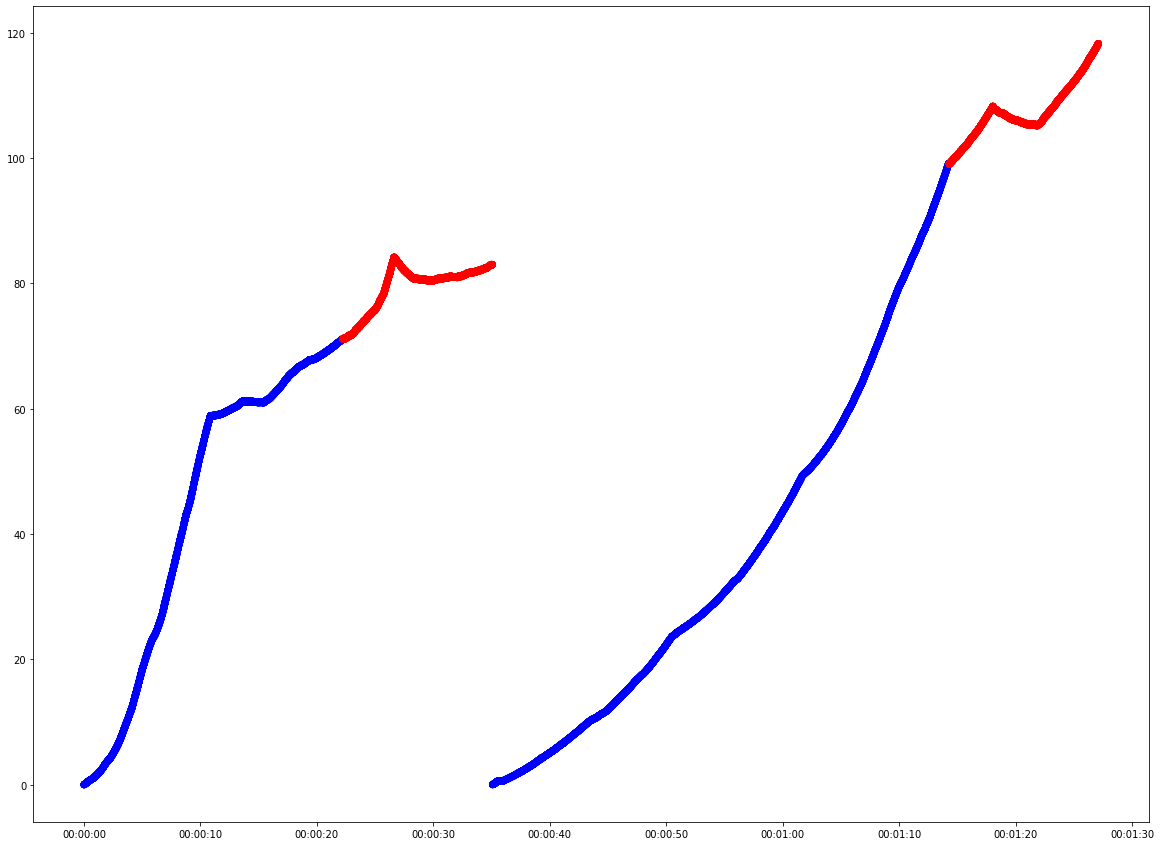

In [ ]:
plt.figure(figsize=(20, 15))
plt.scatter(y = df.Vtotal, x = df.DateTime, c = df.act, cmap=matplotlib.colors.ListedColormap(['blue', 'red']))
plt.show()